In [ ]:
pip install qiskit

In [ ]:
pip install quantuminspire

In [ ]:
pip install qiskit_nature

In [ ]:
pip install PySCF

In [ ]:
from qiskit import Aer
from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver

from qiskit_nature.transformers import ActiveSpaceTransformer
from qiskit_nature.algorithms import GroundStateEigensolver, BOPESSampler
from qiskit.algorithms import NumPyMinimumEigensolver

from qiskit.utils import QuantumInstance

from qiskit_nature.circuit.library.ansatzes import UCCSD
from qiskit_nature.circuit.library.initial_states import HartreeFock
from qiskit.circuit.library import TwoLocal

from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA

from functools import partial as apply_variation_to_atom_pair
import numpy as np
import matplotlib.pyplot as plt

from qiskit import IBMQ, assemble, transpile

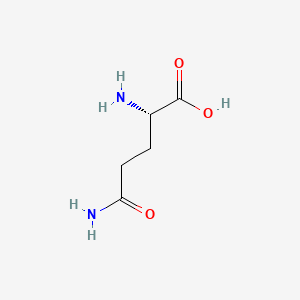

Glutamine molecule is the key protease in SARS-Cov-2. To simulate the whole molecule, 40+ qubits and several weeks of computation time would be required -- unfeasible with current technology. 

However, by reducing the glutamine to NH₂C, we are able to simulate the binding of glutamine with a protease inhibitor, effectively achieving a speedup in the development of new SARS-Cov-2 vaccines.

National Center for Biotechnology Information. "PubChem Compound Summary for CID 5961, Glutamine" PubChem, https://pubchem.ncbi.nlm.nih.gov/compound/Glutamine. Accessed 30 January, 2022.

In [ ]:
variation = Molecule.relative_stretching

#Other types of molecular variation:
#molecular_variation = Molecule.relative_stretching
#molecular_variation = Molecule.absolute_bending
#molecular_variation = Molecule.relative_bending


# Actual molecule that's currently too large

glutamine_molecule = Molecule(geometry=
                              [['O', [-2.1389, 1.637, 0.5099]],
                               ['O', [-2.6773, 0.2475, -1.1973]],
                               ['O', [2.9039, 0.2551, 1.0351]],
                               ['N', [-1.4789,  -1.8922, -0.0291]],
                               ['N', [3.2441, 0.1932, -1.2385]],
                               ['C', [0.1338, -0.2355, 0.8758]],
                               ['C', [-1.3424, -0.6086, 0.659]],
                               ['C', [1.0032,  -0.1458, -0.3839]],
                               ['C', [-2.1158, 0.4356, -0.1257]],
                               ['C', [2.4683, 0.1136, -0.1257]],
                               ['H', [0.1904, 0.7236, -0.1051]],
                               ['H', [0.5783, -0.9764, 1.4071]],
                               ['H', [-0.18319, -0.7041, 1.5545]],
                               ['H', [0.95,-1.0821, -0.9509]],
                               ['H', [0.6339, 0.6568,-1.0331]],
                               ['H', [-1.136,-1.8186,-0.9858]],
                               ['H', [-2.4648,-2.142,-0.0988]],
                               ['H', [2.856,0.078,-2.1693]],
                               ['H', [4.2414,0.3697,-1.1781]],
                               ['H', [-2.645,2.3081,0.0041]],
                               ['C', [-1.4789, -1.8922, -1]]], # Carbon inhibitor
                              charge=0, multiplicity=1)


specific_variation = apply_variation_to_atom_pair(variation, atom_pair=(4, 2))
# Modified version of glutamine
toy_glutamine = Molecule(geometry=
                        [['H', [-0.18319, -0.7041, 1.5545]],
                         ['H', [-1.136,-1.8186,-0.9858]],
                         ['N', [-1.4789,  -1.8922, -0.0291]],
                         ['C', [-1.3424, -0.6086, 0.659]],
                         ['C', [-1.4789, -1.8922, -1]]], # Carbon inhibitor
                          charge=3, multiplicity=1, degrees_of_freedom=[specific_variation]) 

In [ ]:
import os
MAX_MEMORY = int (os.environ.get ('MAX_MEMORY', 80000))## Memory in MB
orbital_maker = PySCFDriver(molecule=toy_glutamine, unit=UnitsType.ANGSTROM, basis='sto3g', max_memory=MAX_MEMORY)
transformer = ActiveSpaceTransformer(num_electrons=2, num_molecular_orbitals=2)
fermonic_hamiltonian = ElectronicStructureProblem(orbital_maker, [transformer])

fermonic_hamiltonian.second_q_ops()
fermions_to_q = QubitConverter(JordanWignerMapper())

In [ ]:
hardware_trial = TwoLocal(num_qubits=5, rotation_blocks = ['rz'], entanglement_blocks = 'cx',
                                   entanglement='full', reps=3, skip_unentangled_qubits=True, skip_final_rotation_layer=True)

#molecule_info = fermonic_hamiltonian.molecule_data_transformed
#num_molecular_orbitals = molecule_info.num_molecular_orbitals
#num_spin_orbitals = 2 * num_molecular_orbitals
#num_electrons_spin_up_spin_down = (
#    molecule_info.num_alpha,
#    molecule_info.num_beta,)
#initial_state = HartreeFock(
#            num_spin_orbitals, num_electrons_spin_up_spin_down, fermions_to_q)

#chemistry_trial = UCCSD(
#            fermions_to_q,
#            num_electrons_spin_up_spin_down,
#            num_spin_orbitals,
#            initial_state=initial_state,
#)



quantum_environment = QuantumInstance(Aer.get_backend('statevector_simulator'))
#provider = IBMQ.load_account()
#quantum_environment = QuantumInstance(provider.backend.ibmq_lima)

# Solve using VQE
vqe = VQE(ansatz=hardware_trial, quantum_instance=quantum_environment)

ground_state = GroundStateEigensolver(fermions_to_q, vqe)
# ground_state = ground_state.solve(fermonic_hamiltonian)

energy_surface = BOPESSampler(gss=ground_state, bootstrap=False)
total_number_of_parameters = len(hardware_trial._ordered_parameters)
print("Total number of adjustable parameters: ", total_number_of_parameters)
energy_surface_result = energy_surface.sample(fermonic_hamiltonian, np.linspace(-0.5, 5, 30))

In [ ]:
job.status()

In [ ]:
#vqe = job
#hardware_trial = TwoLocal(num_qubits=5, rotation_blocks = ['rz'], entanglement_blocks = 'cx',
#                                   entanglement='full', reps=3, skip_unentangled_qubits=True, skip_final_rotation_layer=True)
ground_state = GroundStateEigensolver(fermions_to_q, job.result())
# ground_state = ground_state.solve(fermonic_hamiltonian)

energy_surface = BOPESSampler(gss=ground_state, bootstrap=False)
total_number_of_parameters = len(hardware_trial._ordered_parameters)
print("Total number of adjustable parameters: ", total_number_of_parameters)
energy_surface_result = energy_surface.sample(fermonic_hamiltonian, np.linspace(-0.5, 5, 30))

In [ ]:
def plot_energy_landscape(energy_surface_result):
    if len(energy_surface_result.points) > 1:
      plt.plot(energy_surface_result.points, energy_surface_result.energies, 
      label="VQE Energy")
      plt.xlabel('Atomic distance Deviation(Angstrom)')
      plt.ylabel('Energy (hartree)')
      plt.legend()
      plt.show()
    else:
        print("Total Energy is: ", energy_surface_result.energies[0], "hartree")
        print("(No need to plot, only one configuration calculated.)")

In [ ]:
plot_energy_landscape(energy_surface_result)